<h1> Building a Video Dataset </h1>

In this notebook, we build a generic `Video Dataset` that can be constructed from a basic directory layout. 

The code to construct the dataset is heavily borrowed from [`torchvision`'s `Kinetics400`](https://github.com/pytorch/vision/blob/master/torchvision/datasets/kinetics.py), and is tweaked to accomodate more data augmentations and one key additional argument `frame_stride` (this additional argument required tweaking of some of `torchvision`'s, so I copied over all the scripts that required tweaking and made changes in the folder `visionmod`.

<br>

---


### <u>Things to consider when building a video dataset</u>

* Pretrained models of video datasets require the input videos to be of a certain number of frames i.e. `num_frames` (8, 16, 32 are popular choices). 


* Videos smaller than `num_frames` are ignored. For videos that are larger than `num_frames`, all possible sequences (`clips`) of consecutive frames are computed, and the `step_between_clips` determines the difference between the starting frame of each sequence. 


* **NEW**: Instead of taking consecutive frames of length `num_frames`, it would make sense to add a `frame_stride` argument which would skip frames within each subclip. For example, if you had a `num_frames = 16`, `frame_stride = 2`, you should get one subclip of size shape `(T=8, H, W, C)`which has frame numbers 1, 3, 5, 7, 9, 11, 13, and 15. As far as I know, this isn't practiced anywhere, but could be very useful depending on one's dataset, especially for larger videos where tiny subclips don't make nearly as much sense as the entire clip.<br>
Refer to section **XXXXX** to see how this was made possible.

<br>

*All of the above will be demonstrated visually in this notebook with special dummy videos to make things crystal clear.*

<br>

In [1]:
from utils import *
from imports import *
from tfms_torch import *
from tfms_albumentations import *

Arguments such as `_video_width=0`, `_video_height=0` don't make much sense but are needed for speedy reading of videos. Behind the scenes, `torchvision` uses [`PyAV`](https://github.com/mikeboers/PyAV/), which in turn used `ffmpeg`, to read videos.

## VideoDataset Without `frame_stride`

Modifying `Kinetics400` to accomodate data augmentation from `albumentations`

In [2]:
from torchvision.datasets.utils import list_dir
from torchvision.datasets.folder import make_dataset
from torchvision.datasets.video_utils import VideoClips
from torchvision.datasets.vision import VisionDataset
import pandas as pd

class VideoDataset(VisionDataset):
    """
    Parameters
    ----------
        root : string
            Root directory of the dataset.
            
        frames_per_clip : int
            number of frames in a clip
            
        step_between_clips : int
            number of frames between each clip
            
        transform (callable, optional): A function/transform that  takes in a TxHxWxC video
            and returns a transformed version.

    Returns
    -------
        video : Tensor[T, H, W, C]
            Tensor of shape (T, H, W, C) where `T = num_frames`
            
        audio : Tensor[K, L]: 
            the audio frames, where `K` is the number of channels
            and `L` is the number of points
            
        label : int
            class of the video clip
    """

    def __init__(self, root, frames_per_clip, step_between_clips=1, frame_rate=None,
                 extensions=('mp4',), tfms_torch=None, tfms_albu=None, _precomputed_metadata=None,
                 num_workers=1, _video_width=0, _video_height=0,
                 _video_min_dimension=0, _audio_samples=0):
        super(VideoDataset, self).__init__(root)

        classes      = list(sorted(list_dir(root)))
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        self.samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file=None)
        self.classes = classes
        video_list   = [x[0] for x in self.samples]
        self.video_clips = VideoClips(
            video_list,
            frames_per_clip,
            step_between_clips,
            frame_rate,
            _precomputed_metadata,
            num_workers=num_workers,
            _video_width=_video_width,
            _video_height=_video_height,
            _video_min_dimension=_video_min_dimension,
            _audio_samples=_audio_samples,
        )
        self.tfms_torch = tfms_torch
        self.tfms_albu  = tfms_albu

    @property
    def metadata(self):
        return self.video_clips.metadata

    def get_info(self):
        fnames     = [f.rsplit('/')[-1] for f   in self.video_clips.metadata['video_paths']]
        classes    = [f.rsplit('/')[-2] for f   in self.video_clips.metadata['video_paths']]
        num_frames = [len(pts)          for pts in self.video_clips.metadata['video_pts']]
        fps        = [i                 for i   in self.video_clips.metadata['video_fps']]
        subclips   = [len(x)            for x   in self.video_clips.clips]
        

        info = pd.DataFrame(data    = list(zip(fnames, classes, num_frames, fps, subclips)),
                            columns = ['Filename', 'Class', '# Frames', 'FPS', '# Subclips'])
        return info
    
    def __len__(self):
        return self.video_clips.num_clips()

    def __getitem__(self, idx):
        video, audio, info, video_idx = self.video_clips.get_clip(idx)
        label = self.samples[video_idx][1]

        if self.tfms_albu is None: self.tfms = A.Compose([])
        if self.tfms_torch is not None:
            video = apply_tfms_albu(self.tfms_torch(video), self.tfms_albu)

        return video, audio, label

## Constructing a Minimal VideoDataset and Seeing What's Inside


### Constructed using dummy samples, and without transforms. The goal is to understand how videos are stored by the dataset, and what `step_between_clips` and `frames_per_clip` do.

<br>

In [3]:
!tree ../data/train

../data/train
├── class1
│   ├── c1-sample1.mp4
│   └── c1-sample2.mp4
└── class2
    ├── c2-sample1.mp4
    └── c2-sample2.mp4

2 directories, 4 files


In [4]:
Video('../data/train/class1/c1-sample1.mp4', width=400)
Video('../data/train/class1/c1-sample2.mp4', width=400)
Video('../data/train/class2/c2-sample1.mp4', width=400)
Video('../data/train/class2/c2-sample2.mp4', width=400)

In [5]:
def get_data(step=1, fpclip=32):
    return VideoDataset('../data/train/', step_between_clips=step, frames_per_clip=fpclip)

In [6]:
data = get_data()
data.get_info()
print(f'----------- The dataset has {len(data)} training samples -----------')

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,1
1,c1-sample2.mp4,class1,47,25.0,16
2,c2-sample1.mp4,class2,17,25.0,0
3,c2-sample2.mp4,class2,13,25.0,0


----------- The dataset has 17 training samples -----------


In [7]:
print(f'\nEach sample returns {len(data[0])} items:')
print(f'-----------------------------------------')

print(f'#1 --> Video --> {data[0][0].shape}')
print(f'#2 --> Audio --> {data[0][1].shape}')
print(f'#2 --> Label --> {data[0][2]}')

/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torchvision-0.5.0a0+5eee011-py3.7-macosx-10.7-x86_64.egg/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.



Each sample returns 3 items:
-----------------------------------------
#1 --> Video --> torch.Size([32, 900, 1600, 3])
#2 --> Audio --> torch.Size([2, 31744])
#2 --> Label --> 0


### Step Between Clips = 1,
### Frames Per Clip = 32

<br>

As the data table above tells us, 1 subsample was created from the first sample, 16 from the second, and none from the others. <br>
These 16 samples are 16 consecutive series of 32 frames, from a total of 47 frames. 

<br>

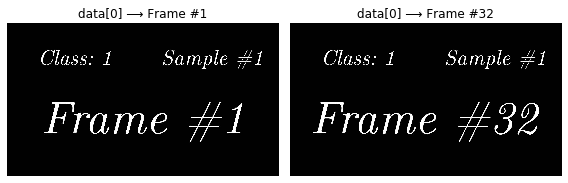

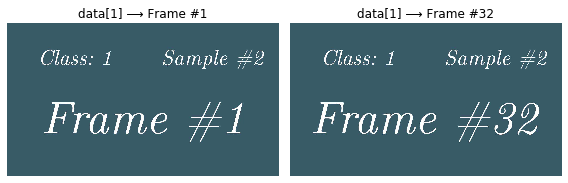

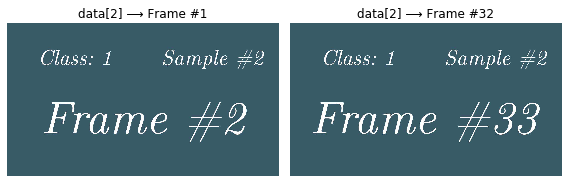

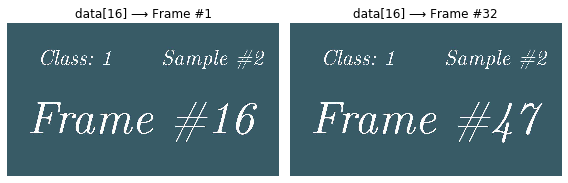

In [8]:
i = 0

plot = lambda i:plot_adjacent(data[i][0], figsize=(8, 6), prefix=f'data[{i}] ⟶ ')

plot(0)
plot(1)
plot(2)
plot(16)

### Step Between Clips = 8,
### Frames Per Clip = 32

In [9]:
data = get_data(step=8, fpclip=32)
data.get_info()

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,1
1,c1-sample2.mp4,class1,47,25.0,2
2,c2-sample1.mp4,class2,17,25.0,0
3,c2-sample2.mp4,class2,13,25.0,0


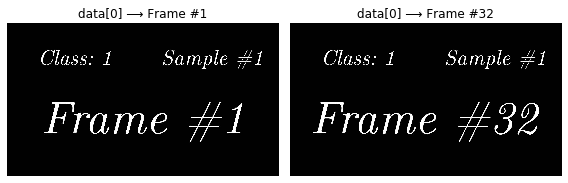

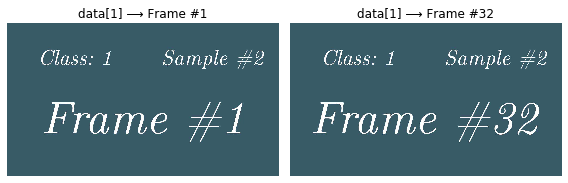

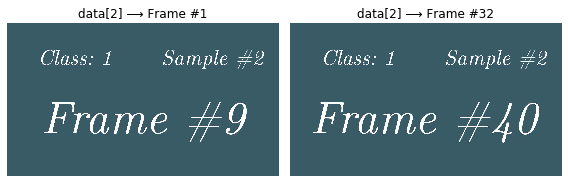

In [10]:
plot(0)
plot(1)
plot(2)

### Step Between Clips = 4,
### Frames Per Clip = 32

In [11]:
data = get_data(step=4, fpclip=32)
data.get_info()

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,1
1,c1-sample2.mp4,class1,47,25.0,4
2,c2-sample1.mp4,class2,17,25.0,0
3,c2-sample2.mp4,class2,13,25.0,0


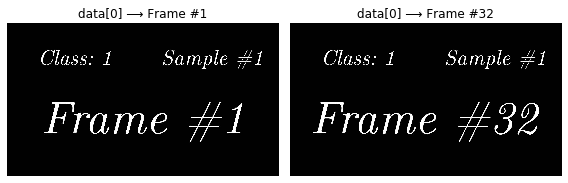

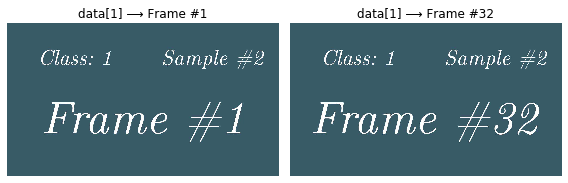

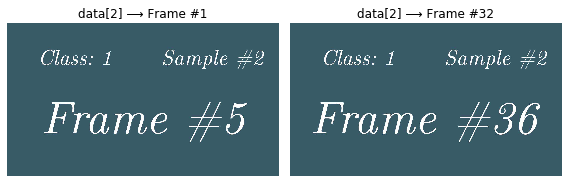

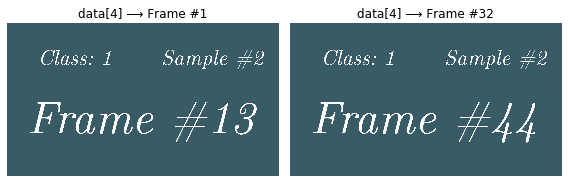

In [12]:
plot(0)
plot(1)
plot(2)
plot(4)

### Step Between Clips = 4,
### Frames Per Clip = 8

In [13]:
data = get_data(step=4, fpclip=8)
data.get_info()

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,7
1,c1-sample2.mp4,class1,47,25.0,10
2,c2-sample1.mp4,class2,17,25.0,3
3,c2-sample2.mp4,class2,13,25.0,2


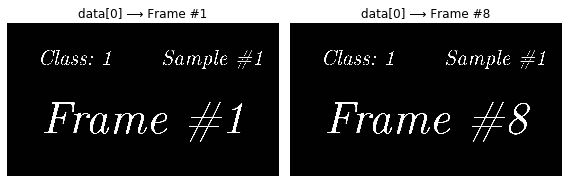

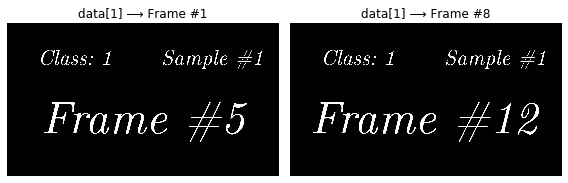

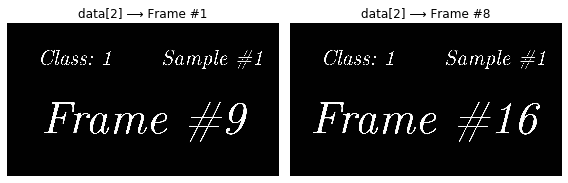

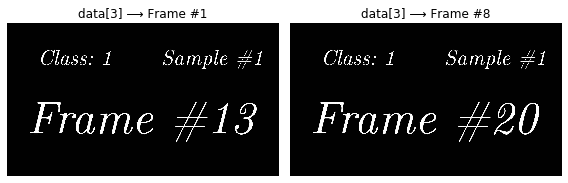

In [14]:
plot = lambda i:plot_adjacent(data[i][0], figsize=(8, 6), j=7, prefix=f'data[{i}] ⟶ ')

plot(0)
plot(1)
plot(2)
plot(3)

## How to add `frame_stride` within a subclip?

A deep dive into `VideoClips` (`torchvision.datasets.video_utils.VideoClips`) and some of its dependencies

In [15]:
from torchvision.datasets.video_utils import *

In [16]:
def get_info(vid):
    fnames     = [f.rsplit('/')[-1] for f   in vid.metadata['video_paths']]
    classes    = [f.rsplit('/')[-2] for f   in vid.metadata['video_paths']]
    num_frames = [len(pts)          for pts in vid.metadata['video_pts']]
    fps        = [i                 for i   in vid.metadata['video_fps']]
    subclips   = [len(x)            for x   in vid.clips]
    
    info = pd.DataFrame(data    = list(zip(fnames, classes, num_frames, fps, subclips)),
                            columns = ['Filename', 'Class', '# Frames', 'FPS', '# Subclips'])
    return info

In [17]:
data = VideoDataset('../data/tmp/', frames_per_clip=32)

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


In [18]:
data.get_info()

,Filename,Class,# Frames,FPS,# Subclips
0,tennis.mp4,tmp-class,42,25.0,11


In [ ]:
torchvision.datasets.video_utils.unfold

#### `VideoClips.compute_clips`

In [19]:
for video_pts, fps in zip(data.video_clips.video_pts, data.video_clips.video_fps):
    clips, idxs = data.video_clips.compute_clips_for_video(video_pts, num_frames=32, step=32, fps=None, frame_rate=data.video_clips.frame_rate)
    data.video_clips.clips.append(clips)
    data.video_clips.resampling_idxs.append(idxs)
clip_lengths = torch.as_tensor([len(v) for v in data.video_clips.clips])
data.video_clips.cumulative_sizes = clip_lengths.cumsum(0).tolist()

In [20]:
num_frames = data.video_clips.num_frames
step       = data.video_clips.step
frame_rate = data.video_clips.frame_rate
clips = []
resampling_idxs = []

video_pts = data.video_clips.video_pts
video_fps = data.video_clips.video_fps

In [21]:
num_frames, step, frame_rate
video_fps
video_pts
len(video_pts[0])

(32, 1, None)

[25.0]

[tensor([    0,   512,  1024,  1536,  2048,  2560,  3072,  3584,  4096,  4608,
          5120,  5632,  6144,  6656,  7168,  7680,  8192,  8704,  9216,  9728,
         10240, 10752, 11264, 11776, 12288, 12800, 13312, 13824, 14336, 14848,
         15360, 15872, 16384, 16896, 17408, 17920, 18432, 18944, 19456, 19968,
         20480, 20992])]

42

In [22]:
if frame_rate is None: frame_rate = fps

total_frames = len(video_pts) * (float(frame_rate) / fps)
total_frames

1.0

In [23]:
idxs = VideoClips._resample_video_idx(int(math.floor(total_frames)), fps, frame_rate)
idxs

slice(None, None, 1)

In [24]:
video_pts = video_pts[idxs]
video_pts

[tensor([    0,   512,  1024,  1536,  2048,  2560,  3072,  3584,  4096,  4608,
          5120,  5632,  6144,  6656,  7168,  7680,  8192,  8704,  9216,  9728,
         10240, 10752, 11264, 11776, 12288, 12800, 13312, 13824, 14336, 14848,
         15360, 15872, 16384, 16896, 17408, 17920, 18432, 18944, 19456, 19968,
         20480, 20992])]

#### `torchvision.datasets.video_utils.unfold`

In [25]:
??unfold

In [26]:
unfold(video_pts[0], num_frames, 1)[:5]

tensor([[    0,   512,  1024,  1536,  2048,  2560,  3072,  3584,  4096,  4608,
          5120,  5632,  6144,  6656,  7168,  7680,  8192,  8704,  9216,  9728,
         10240, 10752, 11264, 11776, 12288, 12800, 13312, 13824, 14336, 14848,
         15360, 15872],
        [  512,  1024,  1536,  2048,  2560,  3072,  3584,  4096,  4608,  5120,
          5632,  6144,  6656,  7168,  7680,  8192,  8704,  9216,  9728, 10240,
         10752, 11264, 11776, 12288, 12800, 13312, 13824, 14336, 14848, 15360,
         15872, 16384],
        [ 1024,  1536,  2048,  2560,  3072,  3584,  4096,  4608,  5120,  5632,
          6144,  6656,  7168,  7680,  8192,  8704,  9216,  9728, 10240, 10752,
         11264, 11776, 12288, 12800, 13312, 13824, 14336, 14848, 15360, 15872,
         16384, 16896],
        [ 1536,  2048,  2560,  3072,  3584,  4096,  4608,  5120,  5632,  6144,
          6656,  7168,  7680,  8192,  8704,  9216,  9728, 10240, 10752, 11264,
         11776, 12288, 12800, 13312, 13824, 14336, 14848, 1

In [27]:
dilation = 1
o_stride = video_pts[0].stride(0)
o_stride
numel    = video_pts[0].numel()
numel

1

42

In [28]:
# new
frame_stride = 2

In [29]:
new_stride = (step * o_stride, dilation * o_stride * frame_stride)
new_stride

(1, 2)

In [30]:
new_size = ((numel - (dilation * (num_frames - 1) + 1)) // step + 1, num_frames // frame_stride)
new_size

(11, 16)

In [31]:
if new_size[0] < 1:
    new_size = (0, size)
new_size

(11, 16)

In [32]:
new_size
new_stride

(11, 16)

(1, 2)

<h2> This is it! </h2>

In [33]:
torch.as_strided(video_pts[0], new_size, new_stride) [:2]

tensor([[    0,  1024,  2048,  3072,  4096,  5120,  6144,  7168,  8192,  9216,
         10240, 11264, 12288, 13312, 14336, 15360],
        [  512,  1536,  2560,  3584,  4608,  5632,  6656,  7680,  8704,  9728,
         10752, 11776, 12800, 13824, 14848, 15872]])

In [34]:
torch.as_strided(video_pts[0], (11, 16), (1,2))  [:2]

tensor([[    0,  1024,  2048,  3072,  4096,  5120,  6144,  7168,  8192,  9216,
         10240, 11264, 12288, 13312, 14336, 15360],
        [  512,  1536,  2560,  3584,  4608,  5632,  6656,  7680,  8704,  9728,
         10752, 11776, 12800, 13824, 14848, 15872]])

#### `VideoClips.get_clip()`

In [35]:
vid_idx, clip_idx = data.video_clips.get_clip_location(2)
vid_idx, clip_idx

(0, 2)

In [36]:
vid_path = data.video_clips.video_paths[vid_idx]
vid_path

'../data/tmp/tmp-class/tennis.mp4'

In [37]:
#new
video_pts = data.video_clips.video_pts[vid_idx]
video_pts

tensor([    0,   512,  1024,  1536,  2048,  2560,  3072,  3584,  4096,  4608,
         5120,  5632,  6144,  6656,  7168,  7680,  8192,  8704,  9216,  9728,
        10240, 10752, 11264, 11776, 12288, 12800, 13312, 13824, 14336, 14848,
        15360, 15872, 16384, 16896, 17408, 17920, 18432, 18944, 19456, 19968,
        20480, 20992])

In [38]:
clip_pts = data.video_clips.clips[vid_idx][clip_idx]
clip_pts

tensor([ 1024,  1536,  2048,  2560,  3072,  3584,  4096,  4608,  5120,  5632,
         6144,  6656,  7168,  7680,  8192,  8704,  9216,  9728, 10240, 10752,
        11264, 11776, 12288, 12800, 13312, 13824, 14336, 14848, 15360, 15872,
        16384, 16896])

#### `torchvision.io.read_video`

In [39]:
from visionmod.io import read_video

In [40]:
start_pts = clip_pts[0].item()
end_pts   = clip_pts[-1].item()
video, audio, info = read_video(vid_path, start_pts, end_pts)

/Users/rahulsomani/01_github_projects/video-classification/notebooks/visionmod/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


In [41]:
#new
start_pts = video_pts[0].item()
end_pts   = video_pts[-1].item()
video, audio, info = read_video(vid_path, start_pts, end_pts)

In [42]:
video.shape

torch.Size([42, 1080, 1920, 3])

In [43]:
clip_pts

tensor([ 1024,  1536,  2048,  2560,  3072,  3584,  4096,  4608,  5120,  5632,
         6144,  6656,  7168,  7680,  8192,  8704,  9216,  9728, 10240, 10752,
        11264, 11776, 12288, 12800, 13312, 13824, 14336, 14848, 15360, 15872,
        16384, 16896])

In [44]:
video_pts

tensor([    0,   512,  1024,  1536,  2048,  2560,  3072,  3584,  4096,  4608,
         5120,  5632,  6144,  6656,  7168,  7680,  8192,  8704,  9216,  9728,
        10240, 10752, 11264, 11776, 12288, 12800, 13312, 13824, 14336, 14848,
        15360, 15872, 16384, 16896, 17408, 17920, 18432, 18944, 19456, 19968,
        20480, 20992])

In [45]:
union_idx = lambda x,y: np.in1d(x.numpy(), y.numpy()).nonzero()
union_idx(video_pts, clip_pts)

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),)

In [46]:
video.shape

torch.Size([42, 1080, 1920, 3])

In [48]:
video[union_idx(video_pts, clip_pts)].shape

torch.Size([32, 1080, 1920, 3])

## Tweaking Torchvision's Code

Copying over the required video-related scripts into the folder `visionmod` and modifying `torchvision.datasets.video_utils` to accomodate `frame_stride`

In [49]:
#export
from visionmod.utils import list_dir
from visionmod.folder import make_dataset
from visionmod.video_utils import VideoClips
from torchvision.datasets.vision import VisionDataset

class VideoDataset(VisionDataset):
    """
    Parameters
    ----------
        root : string
            Root directory of the dataset.
            
        frames_per_clip : int
            number of frames in a clip
            
        step_between_clips : int
            number of frames between each clip
            
        transform (callable, optional): A function/transform that  takes in a TxHxWxC video
            and returns a transformed version.

    Returns
    -------
        video : Tensor[T, H, W, C]
            Tensor of shape (T, H, W, C) where `T = num_frames`
            
        audio : Tensor[K, L]: 
            the audio frames, where `K` is the number of channels
            and `L` is the number of points
            
        label : int
            class of the video clip
    """

    def __init__(self, root, frames_per_clip, step_between_clips=1, frame_stride=1, frame_rate=None,
                 extensions=('mp4',), tfms_torch=None, tfms_albu=None, _precomputed_metadata=None,
                 num_workers=1, _video_width=0, _video_height=0,
                 _video_min_dimension=0, _audio_samples=0):
        super(VideoDataset, self).__init__(root)

        classes      = list(sorted(list_dir(root)))
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        self.samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file=None)
        self.classes = classes
        video_list   = [x[0] for x in self.samples]
        self.video_clips = VideoClips(
            video_list,
            frames_per_clip,
            step_between_clips,
            frame_stride,
            frame_rate,
            _precomputed_metadata,
            num_workers=num_workers,
            _video_width=_video_width,
            _video_height=_video_height,
            _video_min_dimension=_video_min_dimension,
            _audio_samples=_audio_samples,
        )
        self.tfms_torch = tfms_torch
        self.tfms_albu  = tfms_albu

    @property
    def metadata(self):
        return self.video_clips.metadata

    def get_info(self):
        fnames     = [f.rsplit('/')[-1] for f   in self.video_clips.metadata['video_paths']]
        classes    = [f.rsplit('/')[-2] for f   in self.video_clips.metadata['video_paths']]
        num_frames = [len(pts)          for pts in self.video_clips.metadata['video_pts']]
        fps        = [i                 for i   in self.video_clips.metadata['video_fps']]
        subclips   = [len(x)            for x   in self.video_clips.clips]
        

        info = pd.DataFrame(data    = list(zip(fnames, classes, num_frames, fps, subclips)),
                            columns = ['Filename', 'Class', '# Frames', 'FPS', '# Subclips'])
        return info
    
    def __len__(self):
        return self.video_clips.num_clips()

    def __getitem__(self, idx):
        video, audio, info, video_idx = self.video_clips.get_clip(idx)
        label = self.samples[video_idx][1]

        if self.tfms_albu is None: self.tfms = A.Compose([])
        if self.tfms_torch is not None:
            video = apply_tfms_albu(self.tfms_torch(video), self.tfms_albu)

        return video, audio, label

In [50]:
def get_data(step=1, fpclip=32, fstride=2, fr=None):
    return VideoDataset('../data/train/', step_between_clips=step, 
                        frames_per_clip=fpclip, frame_stride=fstride,
                        frame_rate=fr)

In [51]:
data = get_data()
data.get_info()

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


,Filename,Class,# Frames,FPS,# Subclips
0,c1-sample1.mp4,class1,32,25.0,1
1,c1-sample2.mp4,class1,47,25.0,16
2,c2-sample1.mp4,class2,17,25.0,0
3,c2-sample2.mp4,class2,13,25.0,0


In [52]:
data[0][0].shape

torch.Size([16, 900, 1600, 3])

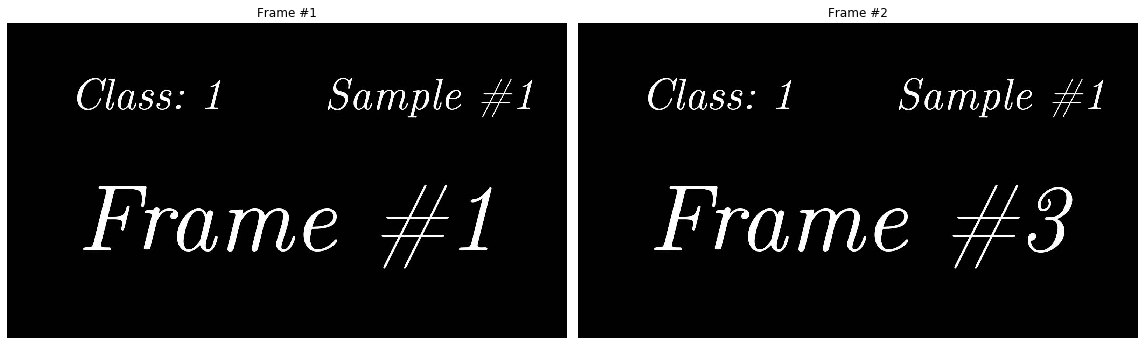

In [53]:
plot_adjacent(data[0][0], i=0,j=1)

## fin